In [1]:
# For autoreloading the classes so you do not need to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Importing the libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(os.path.abspath("../python"))

from EventReader import EventReader
from EventReader import show_data
from Model import SuperResolutionModel
from Model import create_datasets
from ModelUtils import *

In [3]:
r = 2.5 # radius of the detector in cm

In [4]:
# show data in directory
data_dir = '/mnt/c/Users/marjo/data/'
show_data(data_dir)

,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2


In [5]:
# read data
files = glob.glob(data_dir + 'mc0001/*0000.hdf5')
events = EventReader(files)

number of files:  1


In [7]:
# get the necessary information from the events
n = 0
nmax =1000 # if you do not want to loop over all events

true_pos = []
fine_top = []
top = []

for ev in events:
    if n%100 == 0:
        print('processed ', n, 'events')
    n+=1
    
    # retrieve the true hit position
    truth = ev['true_position']
    true_pos.append(truth)
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    top.append(pmt.T)
    fine_pmt = ev['fine_top'][()]
    fine_top.append(fine_pmt.T)

    if n>=nmax:
        print('processed ', nmax, 'events')
        break

events.reset()

processed  0 events
processed  100 events
processed  200 events
processed  300 events
processed  400 events
processed  500 events
processed  600 events
processed  700 events
processed  800 events
processed  900 events
processed  1000 events


In [8]:
print(f"We have {len(top)} events")
print(f"low res PMT has shape {top[0].shape}")
print(f"high res truth has shape {fine_top[0].shape}")
print(f"true positions have shape {true_pos[0].shape}")

We have 1000 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


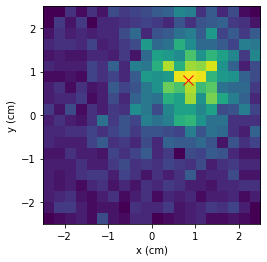

In [9]:
# check if data is ok
num = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(
    top[num], interpolation="nearest", origin="lower", extent=[-r, r, -r, r]
)
ax.imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-2.5, 2.5, -2.5, 2.5],
)
ax.plot(
    true_pos[num][0],
    true_pos[num][1],
    marker="x",
    markersize=10,
    color="red",
    label="true position",
)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

In [11]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(
    X, y, pos, train_fraction=0.8
)
y_train_downsampled = downsample_heatmaps_to_dimensions(y_train, 5, 5)
y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, 5, 5)

In [14]:
# define weighted average estimate as model0
   
wa_pred = weighted_average_estimator(X_test, r=2.5)
wa_mse = mse(pos_test, wa_pred)
wa_r2 = r_squared(pos_test, wa_pred)


In [1]:
# load the trained models
with open('model1.pkl', 'rb') as f:
    model1 = pickle.load(f) #20x20

with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f) #5x5

with open('model_idiot.pkl', 'rb') as f:
    model_idiot = pickle.load(f) #2x2

with open('model3.pkl', 'rb') as f:
    model3 = pickle.load(f) #10x10

with open('model4.pkl', 'rb') as f:
    model4 = pickle.load(f) #15x15

with open('model5.pkl', 'rb') as f:
    model5 = pickle.load(f) #8x8

with open('model6.pkl', 'rb') as f:
    model6 = pickle.load(f) #4x4
    

FileNotFoundError: [Errno 2] No such file or directory: 'model1.pkl'

In [77]:
print("model0: {'MSE': %s, 'R2': %s}" % (wa_mse, wa_r2))
print(f"model1: {model1.evaluate(X_test, y_test, pos_test)}")
print(f"model2: {model2.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 5, 5), pos_test)}")
print(f"model3: {model3.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 10, 10), pos_test)}")
print(f"model4: {model4.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 15, 15), pos_test)}")
print(f"model5: {model5.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 8, 8), pos_test)}")
print(f"model6: {model6.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 4, 4), pos_test)}")
print(f"model_idiot: {model_idiot.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 2, 2), pos_test)}")

model0: {'MSE': 0.5435346459924886, 'R2': 0.790881002400853}
model1: {'MSE': 0.014064304665923464, 'R^2': 0.9945889129325023}
model2: {'MSE': 0.008437138514342806, 'R^2': 0.9967539034324062}
model3: {'MSE': 0.01821868271553785, 'R^2': 0.9929905615122411}
model4: {'MSE': 0.017905969594541066, 'R^2': 0.9931108744580323}
model5: {'MSE': 0.01094550650387426, 'R^2': 0.9957888363415628}
model6: {'MSE': 0.019606381960407107, 'R^2': 0.9924566594377445}
model_idiot: {'MSE': 0.022821157481087394, 'R^2': 0.9912198097919167}


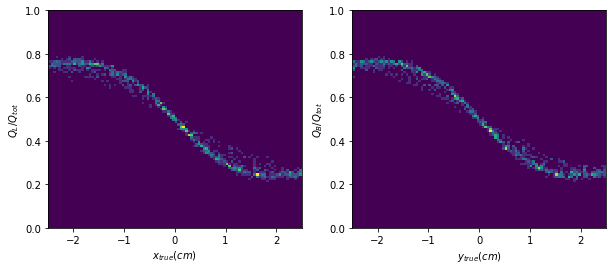

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

qtot = np.sum(np.asarray(X), axis=(1,2))
q_tb = ((np.asarray(X)[:,0,0]+np.asarray(X)[:,0,1])/qtot)
q_lr = ((np.asarray(X)[:,0,0]+np.asarray(X)[:,1,0])/qtot)

h1 = axs[0].hist2d(np.asarray(true_pos)[:,0],q_lr,bins=(100,100), range=((-r,r),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(np.asarray(true_pos)[:,1],q_tb,bins=(100,100), range=((-r,r),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')
plt.show()

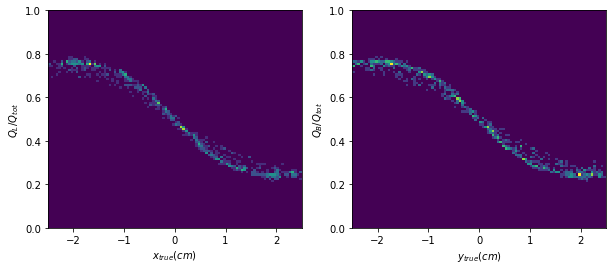

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

qtot = np.sum(np.asarray(X_train), axis=(1,2))
q_tb = ((np.asarray(X_train)[:,0,0]+np.asarray(X_train)[:,0,1])/qtot)
q_lr = ((np.asarray(X_train)[:,0,0]+np.asarray(X_train)[:,1,0])/qtot)

pred_pos = model4.predict(X_train)[1]

h1 = axs[0].hist2d(np.asarray(pred_pos)[:,0],q_lr,bins=(100,100), range=((-r,r),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(np.asarray(pred_pos)[:,1],q_tb,bins=(100,100), range=((-r,r),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')
plt.show()

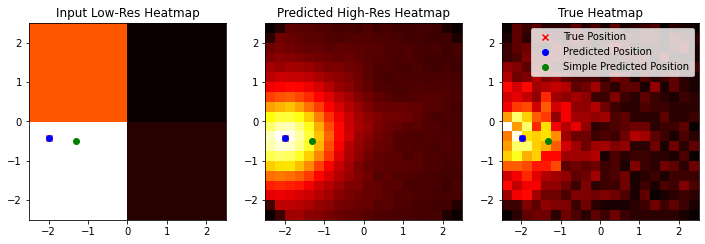

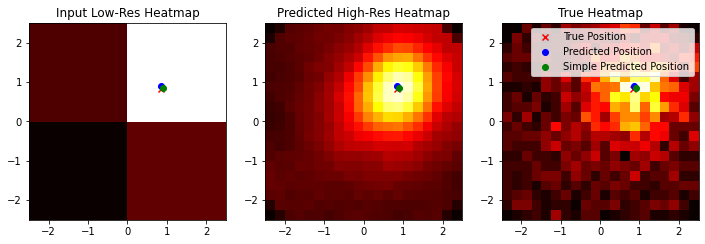

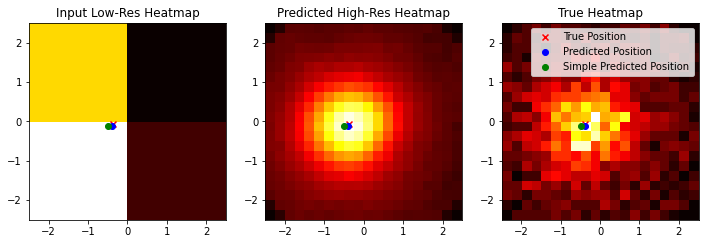

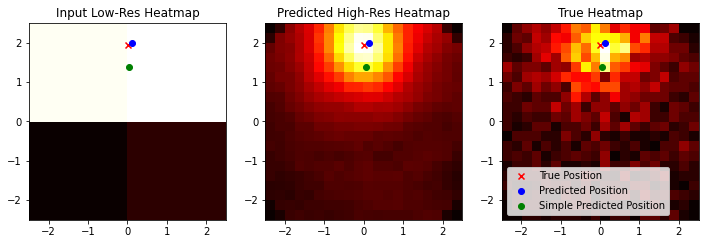

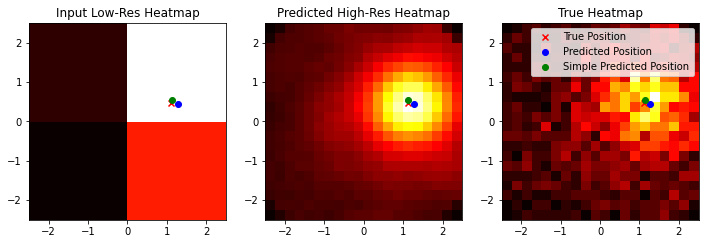

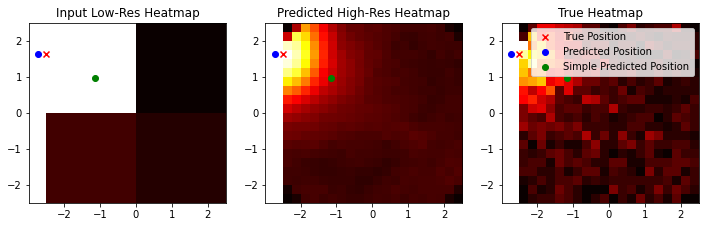

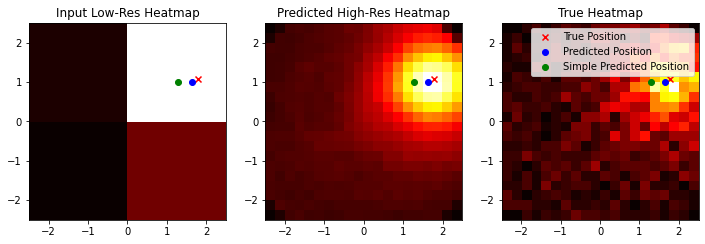

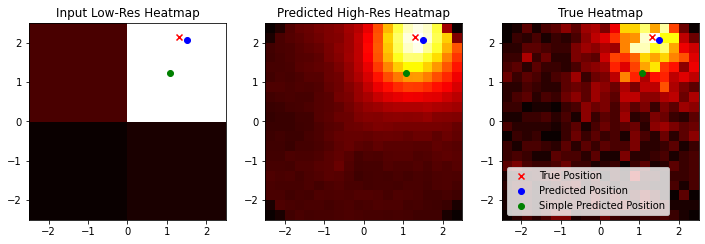

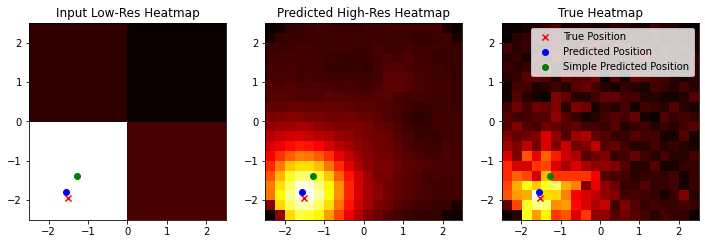

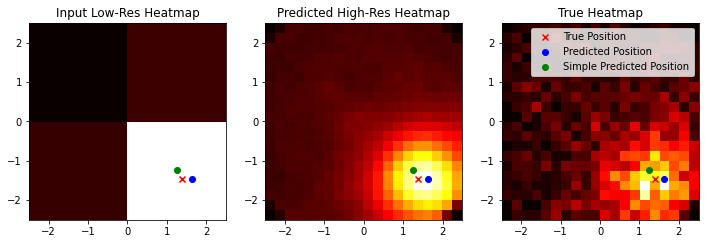

In [80]:
model1.visualize_heatmaps_with_positions(X_train, y_train, pos_train)

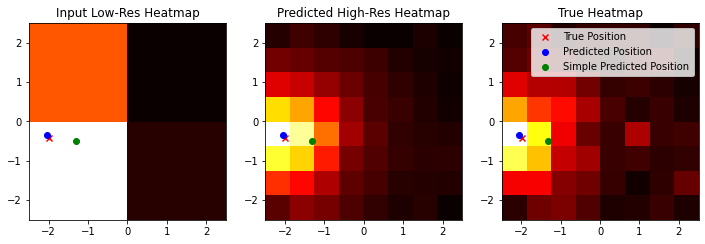

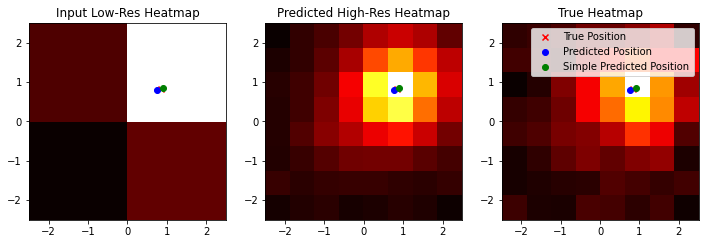

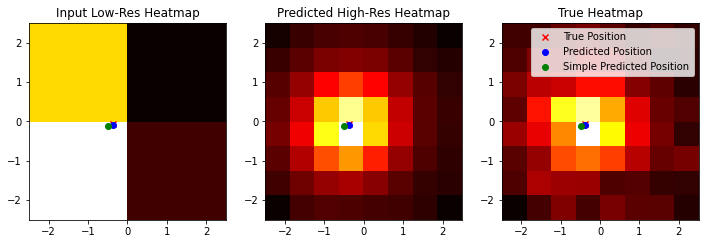

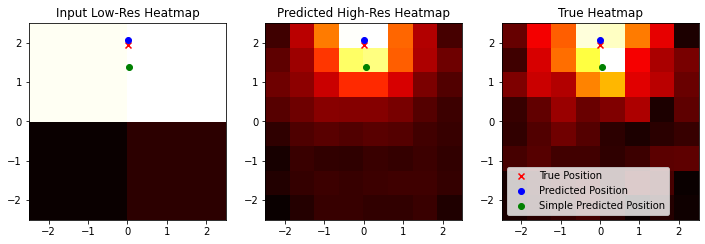

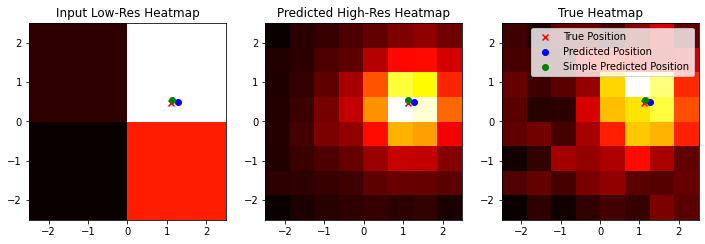

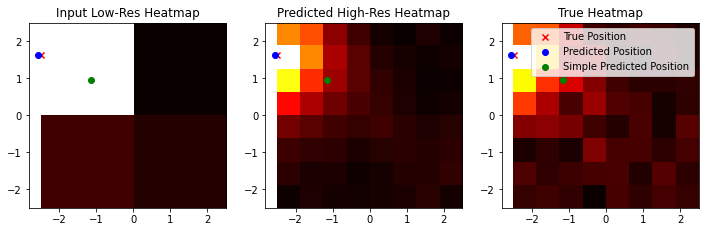

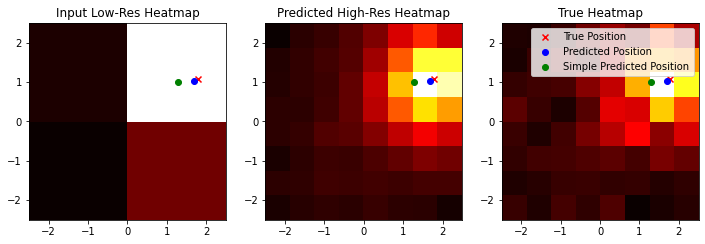

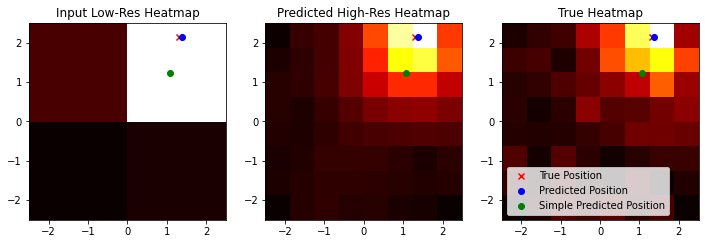

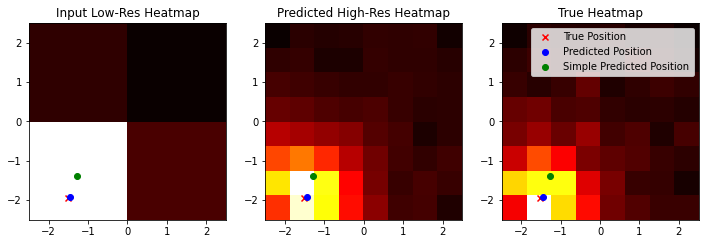

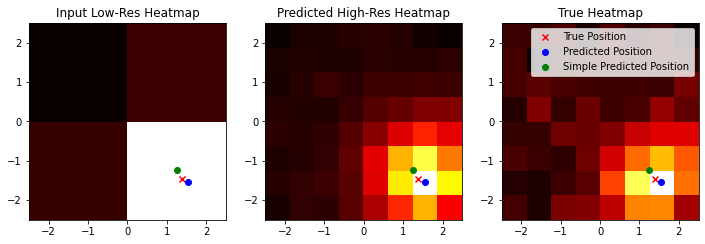

In [81]:
model5.visualize_heatmaps_with_positions(X_train, downsample_heatmaps_to_dimensions(y_train, 8, 8), pos_train)

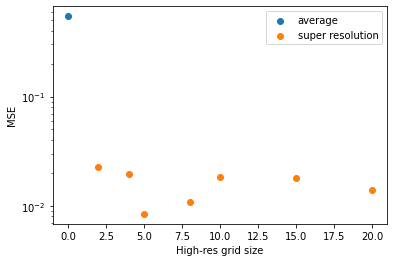

In [85]:
plt.scatter(0, wa_mse, label='average')
plt.scatter(20, model1.evaluate(X_test, y_test, pos_test)['MSE'], c='tab:orange', label='super resolution')
plt.scatter(5, model2.evaluate(X_test, y_test_downsampled, pos_test)['MSE'], c='tab:orange')#, label='model2')
plt.scatter(2, model_idiot.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 2, 2), pos_test)['MSE'], c='tab:orange')#, label='model_idiot')
plt.scatter(10, model3.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 10, 10), pos_test)['MSE'], c='tab:orange')#, label='model3')
plt.scatter(15, model4.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 15, 15), pos_test)['MSE'], c='tab:orange')#, label='model4')
plt.scatter(8, model5.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 8, 8), pos_test)['MSE'], c='tab:orange')#, label='model5')
plt.scatter(4, model6.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, 4, 4), pos_test)['MSE'], c='tab:orange')#, label='model6')
plt.yscale('log')
plt.xlabel('High-res grid size')
plt.ylabel('MSE')
plt.legend()
plt.show()